# Extend Hanna & Olken (2018)
## Universal Basic Incomes versus Targeted Transfers: Anti-Poverty Programs in Developing Countries

Consider different budget levels, and a mix of UBI and targeted transfers.

## Setup

In [0]:
!pip install pandarallel

In [0]:
!pip install git+git://github.com/maxghenis/microdf.git

  Cloning git://github.com/maxghenis/microdf.git to /tmp/pip-req-build-swa28cn9
  Running command git clone -q git://github.com/maxghenis/microdf.git /tmp/pip-req-build-swa28cn9
  Created wheel for microdf: filename=microdf-0.1-cp36-none-any.whl size=18650 sha256=dfb5b8527a8aeaefc3f7f38472341fc3ada42b1941bfb8616ce9745685aa12f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-dktr0zx_/wheels/d0/61/d3/083d3677aa1ee6b248d229cb6c4de037f9d61b595e9f06aed0
Successfully built microdf


In [0]:
import pandas as pd
import numpy as np
import os
import microdf as mdf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
mdf.set_plot_style()

--2020-02-07 05:47:05--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2020-02-07 05:47:06--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘Roboto-Regular.ttf.1’

Roboto-Regular.ttf. 100%[===================>] 141.94K  --.-KB/s    in 0.02s   

2020-02-07 05:47:06 (6.51 MB/s) - ‘Roboto-Regular.ttf.1’ saved [145348/145348]



In [0]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load data

[This notebook](https://colab.research.google.com/drive/1dxg8kjXHV7Fc-qKlaA0LjNPFrzLD0JVM) downloads this file directly from the Census Bureau.

In [0]:
SPM_COLS = ['SPM_ID', 'SPM_NUMPER', 'SPM_RESOURCES', 'SPM_POVTHRESHOLD',
            'SPM_WEIGHT']

In [0]:
raw = pd.read_csv(
    'https://github.com/MaxGhenis/datarepo/raw/master/pppub19.csv.gz',
    usecols=SPM_COLS + ['MARSUPWT'])

Source: [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=US) (as of 2018)

In [0]:
US_GDP = 20.5e12

## Preprocess

In [0]:
u = raw.groupby(SPM_COLS).sum()
u.reset_index([i for i in SPM_COLS if i != 'SPM_ID'], inplace=True)

Define `y` to be resources per person. Set values below \$1 to \$1 so that CRRA works.

In [0]:
u['y0'] = np.maximum(1., u.SPM_RESOURCES / u.SPM_NUMPER)

In [0]:
u['w'] = u.SPM_WEIGHT / 100

Assign weighted rank by income.

In [0]:
u.sort_values('y0', inplace=True)
u['y0_rank'] = u.w.cumsum()
u['y0_pr'] = u.y0_rank / u.w.sum()

### Add noisy income

The actual value of the noisy income isn't important, since it's only used for ranking households. Therefore, random normal noise is sufficient.

Set noise level to match Hanna and Olken's model:
> The typical fit we found of these regressions (the R2) is between 0.53 and 0.66

Their [appendix](https://www.aeaweb.org/content/file?id=8344) shows that they were predicting log income.

Shoot for average: 0.595.

In [0]:
np.random.seed(0)

In [0]:
TARGET_R2 = 0.595

In [0]:
def log_noise(y, noise_mean):
    return np.exp(np.log(y) + noise_mean * np.random.randn(len(y)))

In [0]:
def r2(noise_mean):
    y_noise = log_noise(u.y0, noise_mean)
    r = np.corrcoef(np.log(u.y0), np.log(y_noise))[0, 1]
    return np.power(r, 2)

In [0]:
NOISE_LEVEL = 1.37
r2(NOISE_LEVEL)  # Close to 0.595.

0.5981376687619925

In [0]:
r2(NOISE_LEVEL * 2)

0.2709802289873748

In [0]:
u['y0_l_noise'] = log_noise(u.y0, NOISE_LEVEL)
u['y0_h_noise'] = log_noise(u.y0, NOISE_LEVEL * 2)

Re-rank.

In [0]:
u.sort_values('y0_l_noise', inplace=True)
u['y0_rank_l_noise'] = u.w.cumsum()
u['y0_pr_l_noise'] = u.y0_rank_l_noise / u.w.sum()

In [0]:
u.sort_values('y0_h_noise', inplace=True)
u['y0_rank_h_noise'] = u.w.cumsum()
u['y0_pr_h_noise'] = u.y0_rank_h_noise / u.w.sum()

Check R-squared from noisy to true income rank.

**Low noise**

In [0]:
u[['y0_rank', 'y0_rank_l_noise']].corr().iloc[0, 1]

0.5128437390086074

**High noise**

In [0]:
u[['y0_rank', 'y0_rank_h_noise']].corr().iloc[0, 1]

0.3205836508134436

## Analysis

### Define CRRA function

In [0]:
def crra(y, w=None, rho=3):
    """ Constant relative risk-aversion social welfare function.

    Args:
        y: Array of after-tax after-transfer income.
        w: Optional array of weights. Should be the same length as y.
        rho: Coefficient of relative risk-aversion, where higher values of rho
             put higher weights on transfers received by the very poor.
             Defaults to 3 per Hanna and Olken (2018).
        
    Returns:
        CRRA SWF. Also sets any value below 1 to 1.
    """
    num = np.power(np.array(y, dtype=float), 1 - rho)
    if w is not None:
        num *= w
    return num.sum() / (1 - rho)

Status quo CRRA value.

In [0]:
crra0 = crra(u.y0, u.w)
crra0

-1542708.9725729444

### Define horizontal equity function

From Hanna and Olken (2018):
>At each cutoff c, we calculate, for each household, the percentage of households within ±5 income percentiles (based on actual income) that received the same benefit status—included or excluded—based on the results of proxy-means test prediction. In other words, for households that were included in the program at a given c, we calculate the percentage of similar households that were also included; for households that were excluded, we calculate the percentage of similar households that were also excluded.

**TODO**

### Define simulation function

In [0]:
total_hhs = u.w.sum()  # Number of SPM units.

In [0]:
def simulate(budget_share_of_gdp, pr_threshold, ubi_share, income_pr_col):
    """ Simulate a transfer split between targeted and UBI components.

    Args:
        budget_share_of_gdp: Total budget to be split between targeted and UBI
                             components, as a share of US GDP (0 to 100).
        pr_threshold: Percentrank below which households get the targeted
                      transfer. 0 to 100.
        ubi_share: Number between 0 and 100 representing the share of the
                   transfer that goes to a UBI.
        income_col: Column indicating the income percent rank (true or noisy).
    
    Returns:
    """
    budget = US_GDP * budget_share_of_gdp / 100
    ubi_budget = budget * (ubi_share / 100)
    targeted_budget = budget * (1 - ubi_share / 100)
    ubi_amount = ubi_budget / total_hhs
    target_idx = u[income_pr_col] < (pr_threshold / 100)
    target_hhs = u[target_idx].w.sum()
    targeted_amount = targeted_budget / target_hhs
    return u.y0 + ubi_amount + np.where(target_idx, targeted_amount, 0)

## Simulate

Cartesian product function from https://github.com/MaxGhenis/microdf/blob/master/microdf/utils.py

In [0]:
SIMX = {
    'budget_share_of_gdp': [0.01, 0.1, 0.2, 0.5, 1, 5],
    'noise_col': ['y0_pr', 'y0_pr_l_noise', 'y0_pr_h_noise'],
    'pr_threshold': np.arange(0, 101, 1),
    'ubi_share': np.arange(0, 101, 1)
    }
sim = mdf.cartesian_product(SIMX)

Usually takes 25 minutes.

**SKIP**

In [0]:
sim = pd.read_csv('https://github.com/MaxGhenis/hanna_olken/raw/master/sim.csv')

In [0]:
# %%time
# sim['crra'] = sim.parallel_apply(
#     lambda row: crra(simulate(row.budget_share_of_gdp, row.pr_threshold,
#                               row.ubi_share, row.noise_col)),
#     axis=1)

Make the noise column a category.

In [0]:
sim['noise'] = pd.Categorical(
    np.where(sim.noise_col == 'y0_pr', 'No noise',
             np.where(sim.noise_col == 'y0_pr_l_noise', 'Low noise',
                      'High noise')),
                      categories = ['No noise', 'Low noise', 'High noise'])

In [0]:
sim.drop(['noise_col', 'Unnamed: 0'], axis=1, inplace=True)

## Visualize

### No UBI

Comparable to Hanna and Olken.

In [0]:
def single_plot(budget_share_of_gdp, ubi_share, noise):
    ax = sim[(sim.budget_share_of_gdp == budget_share_of_gdp) &
             (sim.ubi_share == ubi_share) &
             (sim.noise == noise)].plot('pr_threshold', 'crra')
    plt.title('CRRA by share given transfer, ' + str(budget_share_of_gdp) +
              '% of GDP, ' + noise, loc='left')
    plt.xlabel('Percent of households to which transfer is targeted')
    ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_yscale('symlog', linthreshy=-sim.crra.max())
    ax.get_legend().remove()
    plt.show()

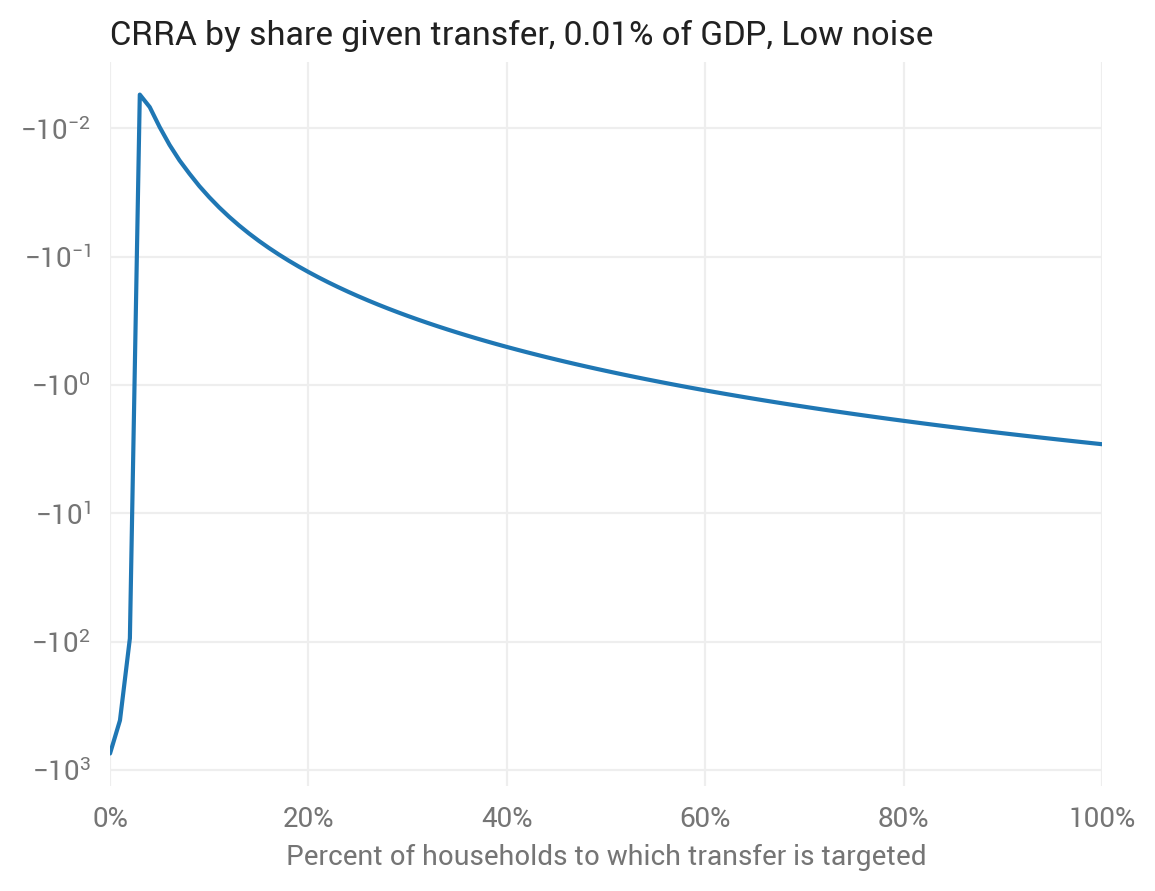

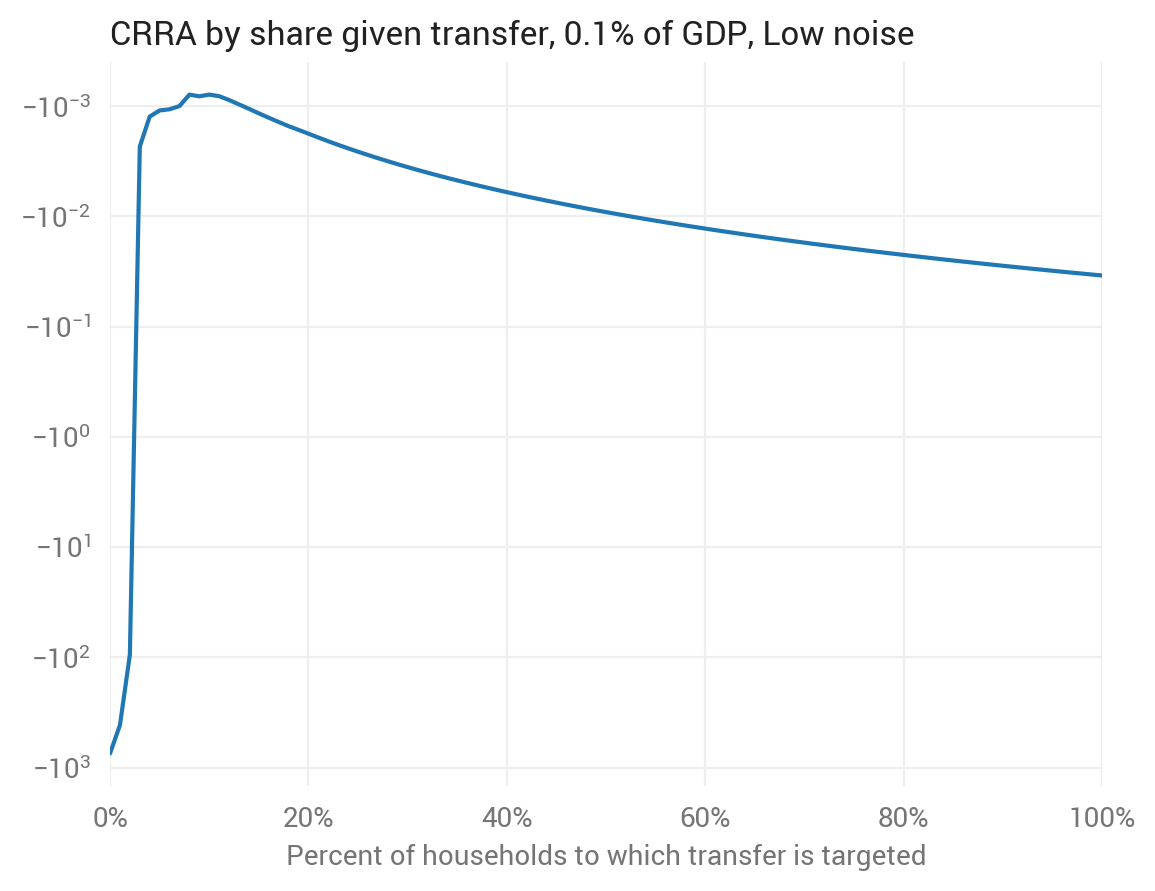

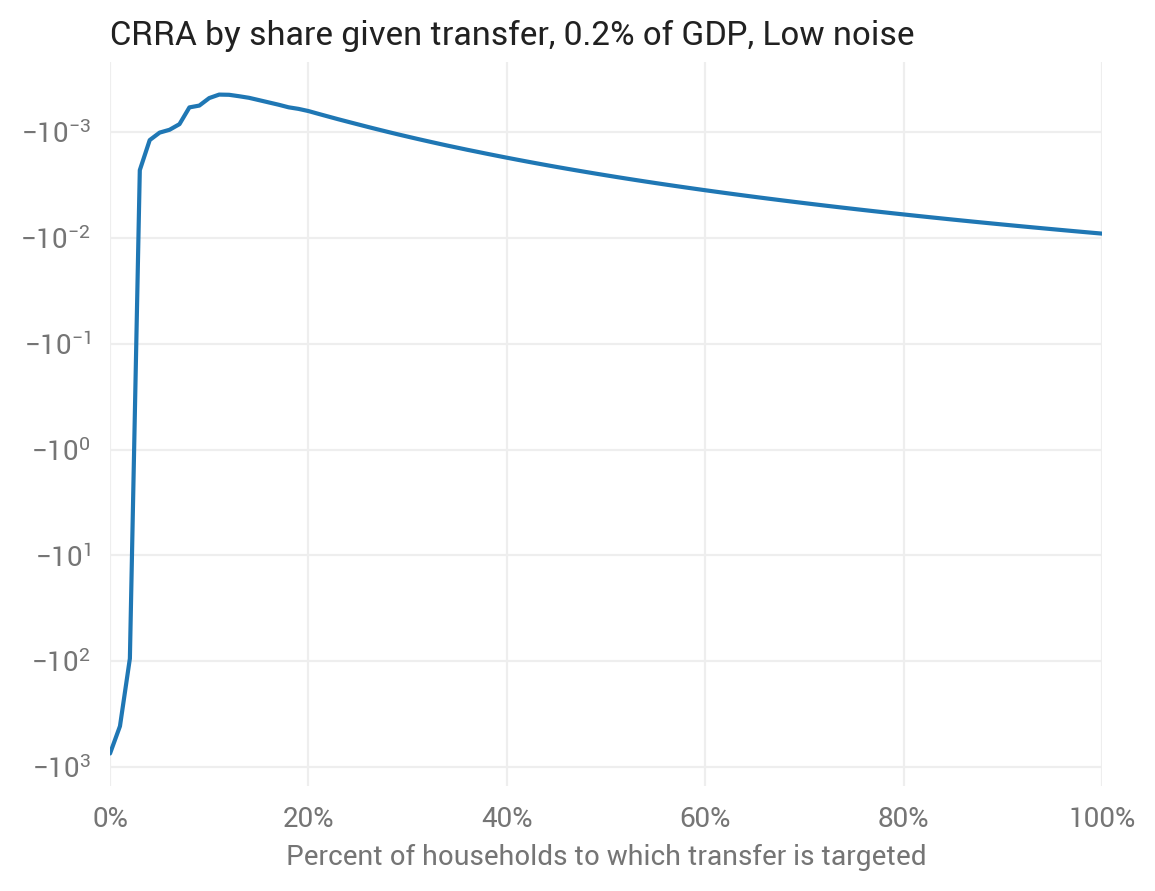

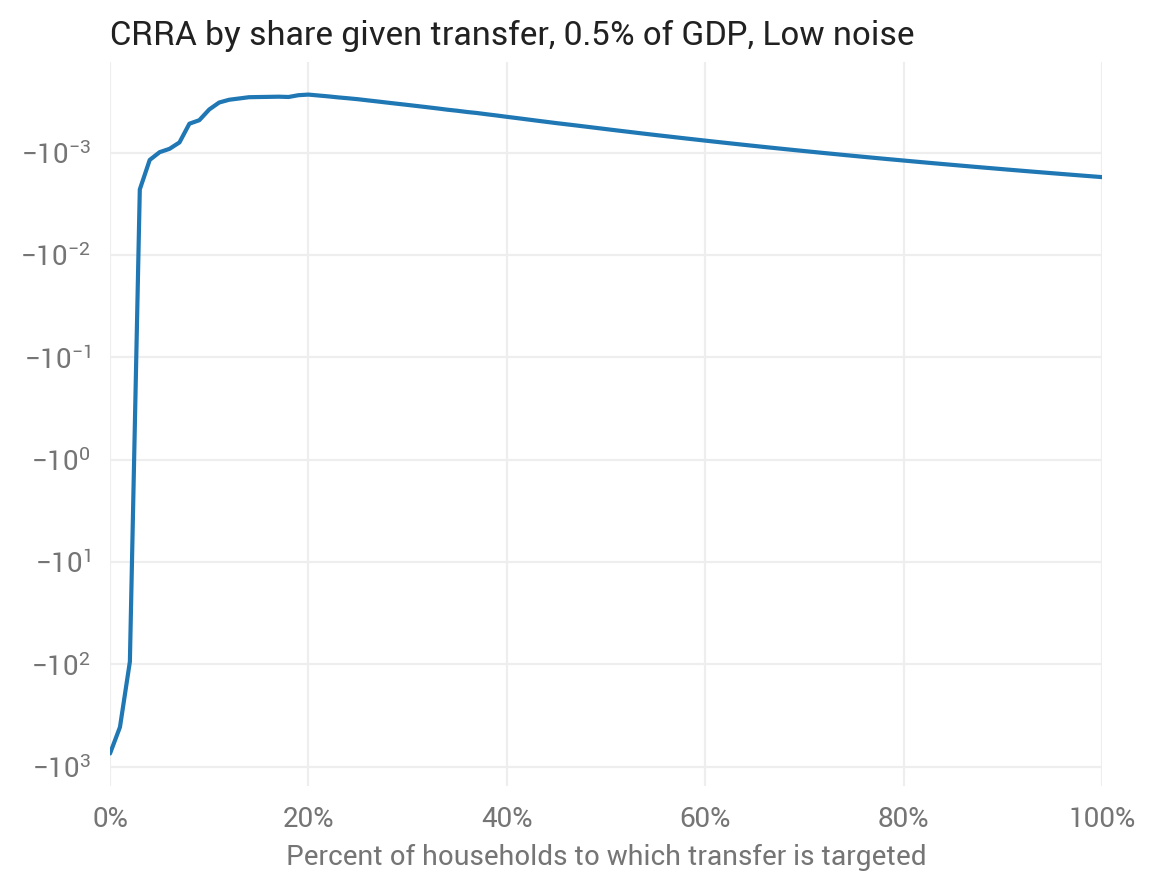

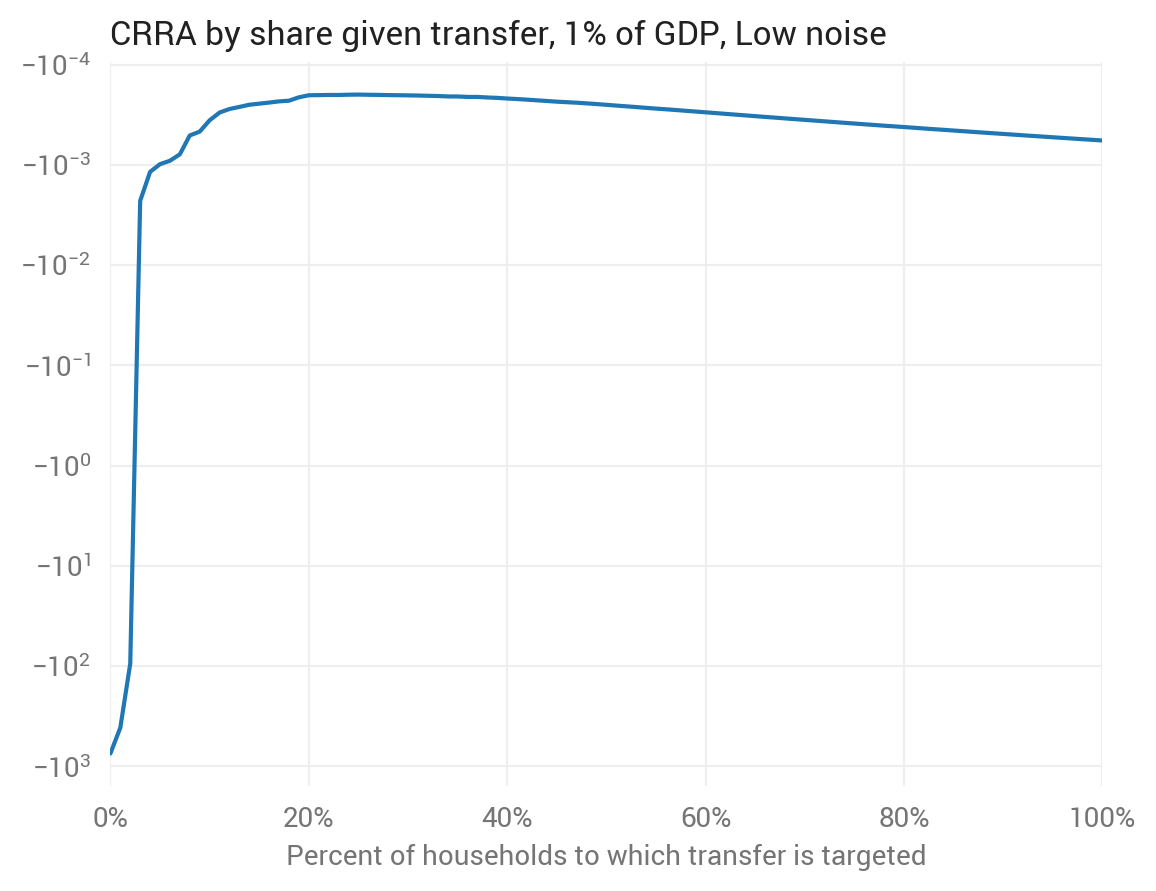

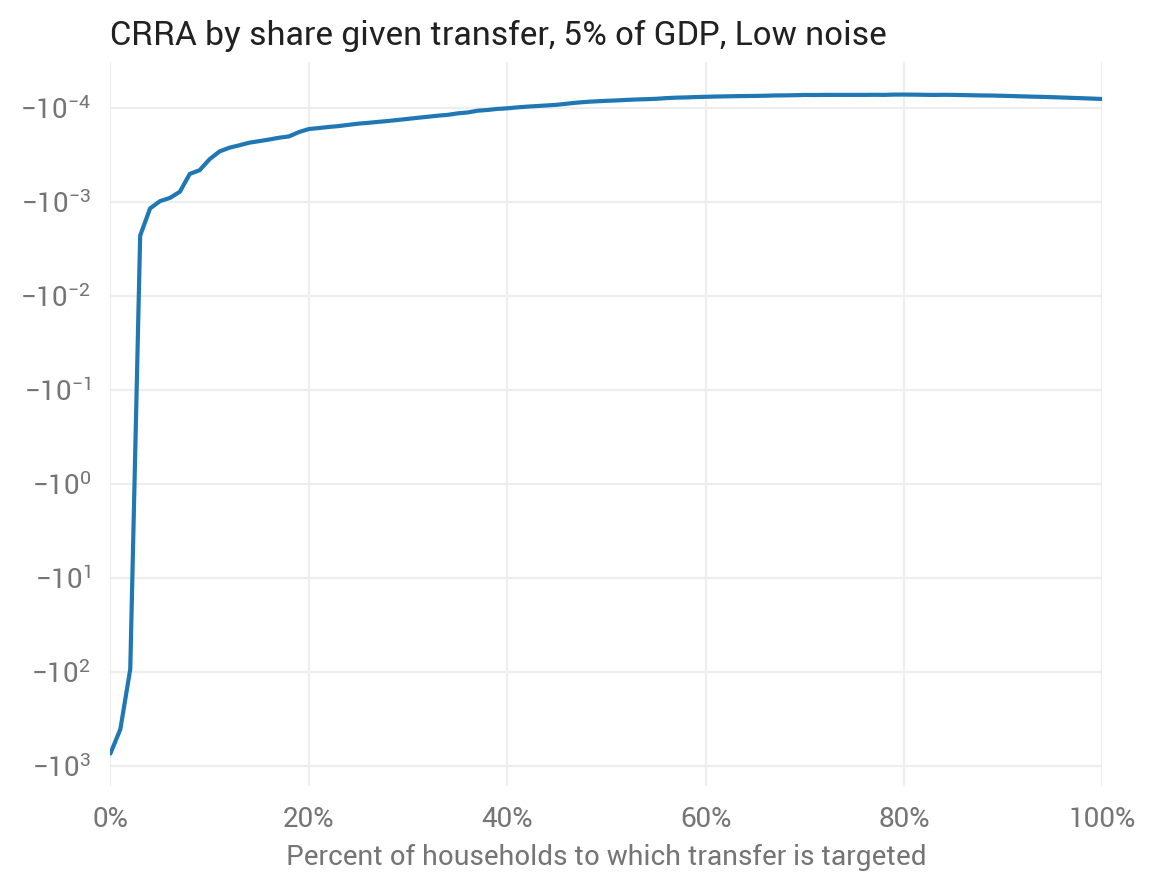

In [0]:
for budget in SIMX['budget_share_of_gdp']:
    single_plot(budget, 0, 'Low noise')

Single chart.

In [0]:
def plot_by_budget(ubi_share, noise):
    by_budget = sim[(sim.ubi_share == ubi_share) &
                    (sim.noise == noise)].pivot(
                        'pr_threshold', 'budget_share_of_gdp', 'crra')
    ax = by_budget.plot()
    plt.title('CRRA by share given transfer and program size, ' + noise,
              loc='left')
    plt.xlabel('Percent of households to which transfer is targeted')
    ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_yscale('symlog', linthreshy=-sim.crra.max())
    ax.legend([str(i) + '%' for i in by_budget.columns], title='Share of GDP')
    plt.show()

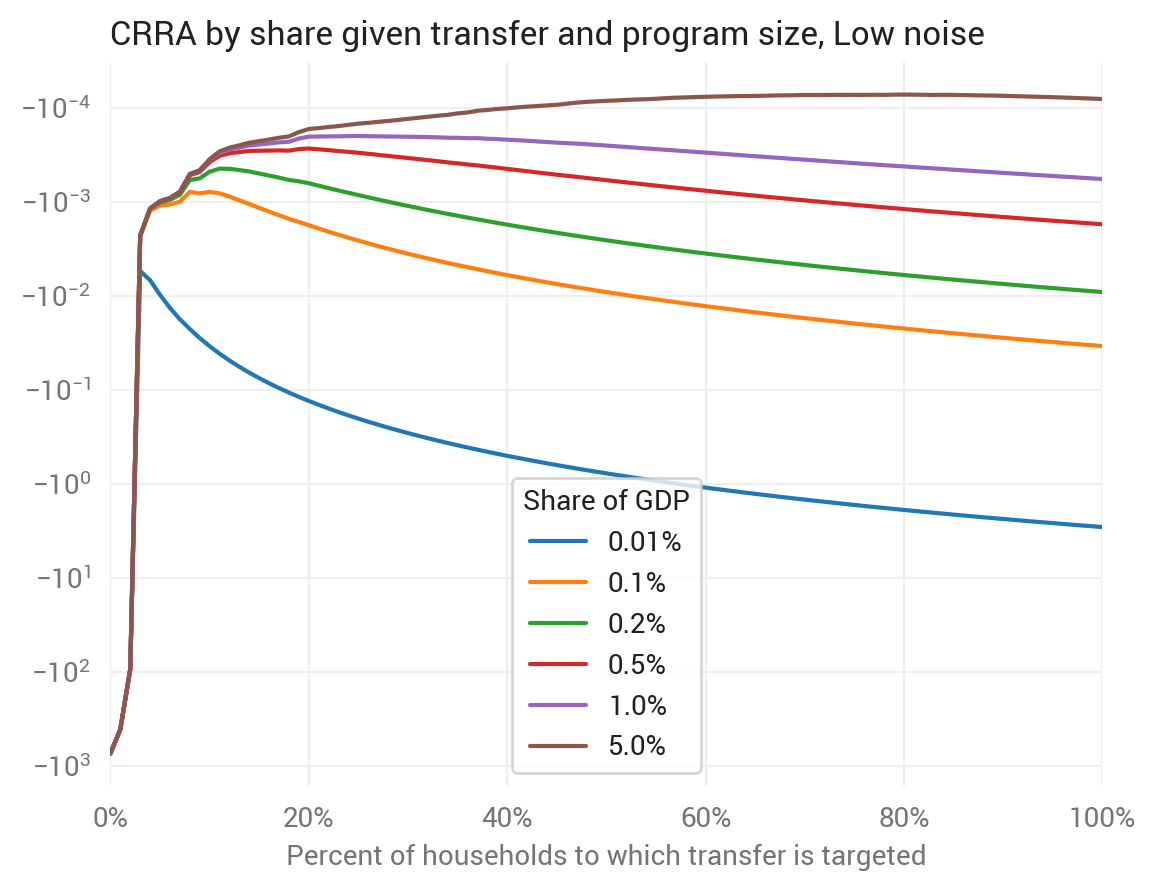

In [0]:
plot_by_budget(0, 'Low noise')

### Optimal targeting by condition

#### No UBI

In [0]:
optimal_targeting_no_ubi = sim[sim.ubi_share == 0].sort_values(
    'crra', ascending=False).drop_duplicates(
        ['budget_share_of_gdp', 'noise']).sort_values(
            ['budget_share_of_gdp', 'noise']).set_index(
                ['budget_share_of_gdp', 'noise']).drop('ubi_share', axis=1)

In [0]:
optimal_targeting_no_ubi_join = optimal_targeting_no_ubi.copy(deep=True)
optimal_targeting_no_ubi_join.columns = pd.MultiIndex.from_product(
    [['No UBI'], optimal_targeting_no_ubi.columns.tolist()])

In [0]:
optimal_targeting_no_ubi_pivot = optimal_targeting_no_ubi.reset_index().pivot(
    'budget_share_of_gdp', 'noise', ['pr_threshold', 'crra'])

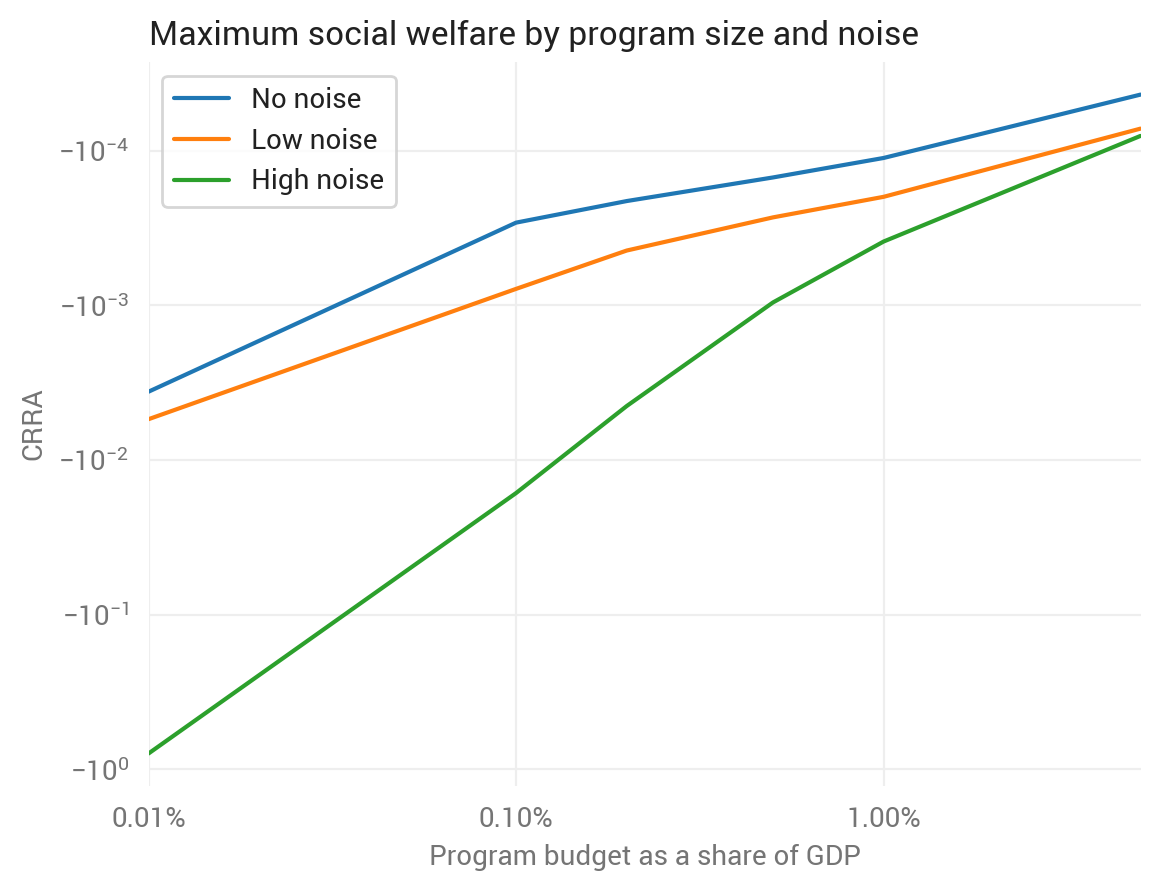

In [0]:
ax = optimal_targeting_no_ubi_pivot.crra.plot()
plt.title('Maximum social welfare by program size and noise', loc='left')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
plt.xlabel('Program budget as a share of GDP')
plt.ylabel('CRRA')
ax.set_yscale('symlog', linthreshy=-sim.crra.max())
plt.legend(title='')
plt.show()

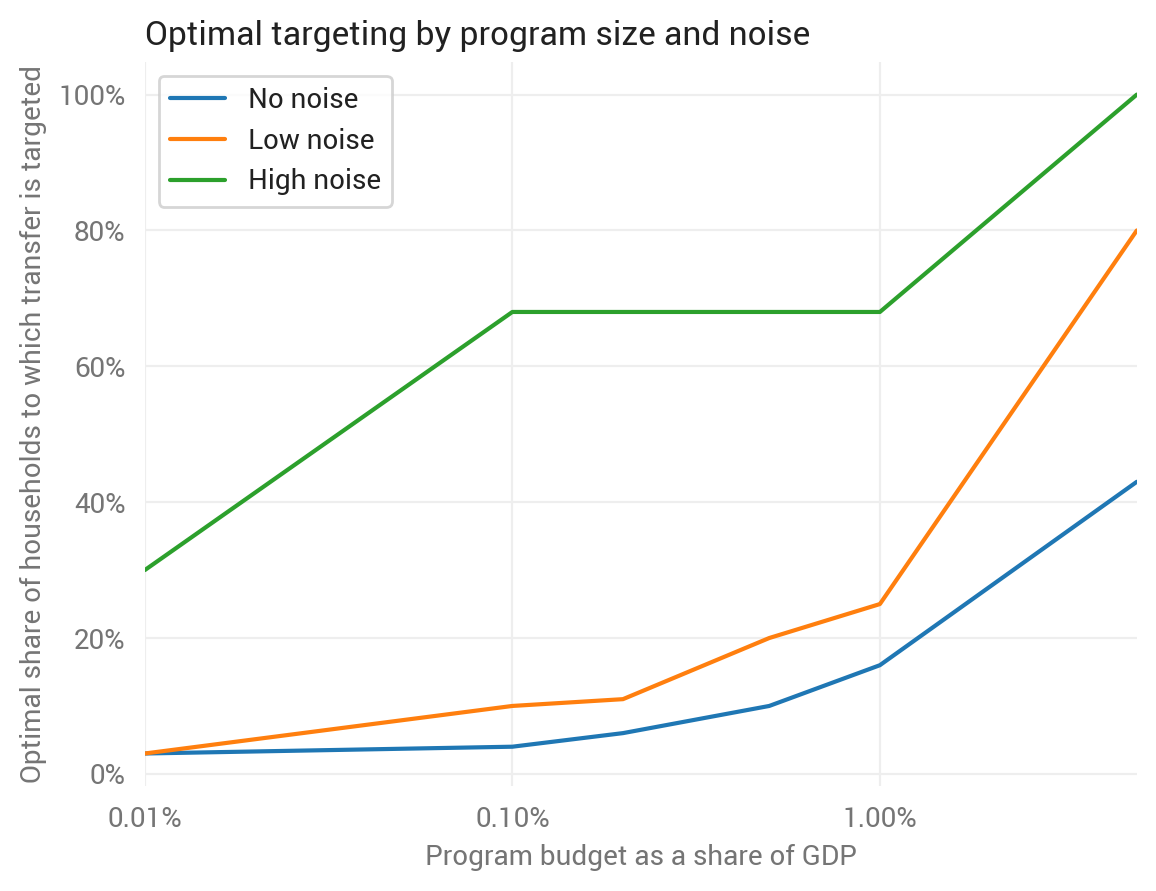

In [0]:
ax = optimal_targeting_no_ubi_pivot.pr_threshold.plot()
plt.title('Optimal targeting by program size and noise', loc='left')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.PercentFormatter())
plt.xlabel('Program budget as a share of GDP')
plt.ylabel('Optimal share of households to which transfer is targeted')
plt.legend(title='')
plt.show()

#### With UBI

In [0]:
optimal_targeting_ubi = sim.sort_values(
    'crra', ascending=False).drop_duplicates(
        ['budget_share_of_gdp', 'noise']).sort_values(
            ['budget_share_of_gdp', 'noise']).set_index(
                ['budget_share_of_gdp', 'noise'])

In [0]:
optimal_targeting_ubi_join = optimal_targeting_ubi.copy(deep=True)
optimal_targeting_ubi_join.columns = pd.MultiIndex.from_product(
    [['With UBI'], optimal_targeting_ubi.columns.tolist()])

In [0]:
optimal_targeting_joined = optimal_targeting_no_ubi_join.join(optimal_targeting_ubi_join)
optimal_targeting_joined['improvement'] = 1 - optimal_targeting_joined['With UBI'].crra / optimal_targeting_joined['No UBI'].crra
optimal_targeting_joined

No UBI            ...  With UBI improvement
                               pr_threshold      crra  ...      crra            
budget_share_of_gdp noise                              ...                      
0.01                No noise              3 -0.003620  ... -0.003620    0.000000
                    Low noise             3 -0.005451  ... -0.005451    0.000000
                    High noise           30 -0.790044  ... -0.278613    0.647345
0.10                No noise              4 -0.000292  ... -0.000292    0.000000
                    Low noise            10 -0.000784  ... -0.000782    0.001631
                    High noise           68 -0.016367  ... -0.004304    0.737060
0.20                No noise              6 -0.000212  ... -0.000212    0.000000
                    Low noise            11 -0.000443  ... -0.000443    0.000000
                    High noise           68 -0.004482  ... -0.001491    0.667242
0.50                No noise             10 -0.000149  ... -0.000149    0.000000
                    Low noise            20 -0.000270  ... -0.000270    0.000000
                    High noise           68 -0.000959  ... -0.000499    0.479528
1.00                No noise             16 -0.000112  ... -0.000112    0.000000
                    Low noise            25 -0.000199  ... -0.000192    0.034896
                    High noise           68 -0.000387  ... -0.000268    0.308615
5.00                No noise             43 -0.000043  ... -0.000043    0.000000
                    Low noise            80 -0.000072  ... -0.000066    0.083138
                    High noise          100 -0.000080  ... -0.000071    0.114660

[18 rows x 6 columns]

### Graphs by noise level

In [0]:
def plot_by_noise(budget_share_of_gdp, ubi_share):
    by_noise = sim[(sim.budget_share_of_gdp == budget_share_of_gdp) &
                   (sim.ubi_share == ubi_share)].pivot(
                        'pr_threshold', 'noise', 'crra')
    ax = by_noise.plot()
    plt.title('CRRA by share given transfer and noise, ' + 
              str(budget_share_of_gdp) + '% of GDP',
              loc='left')
    plt.xlabel('Percent of households to which transfer is targeted')
    ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_yscale('symlog', linthreshy=-sim.crra.max())
    ax.legend(title='')
    plt.show()

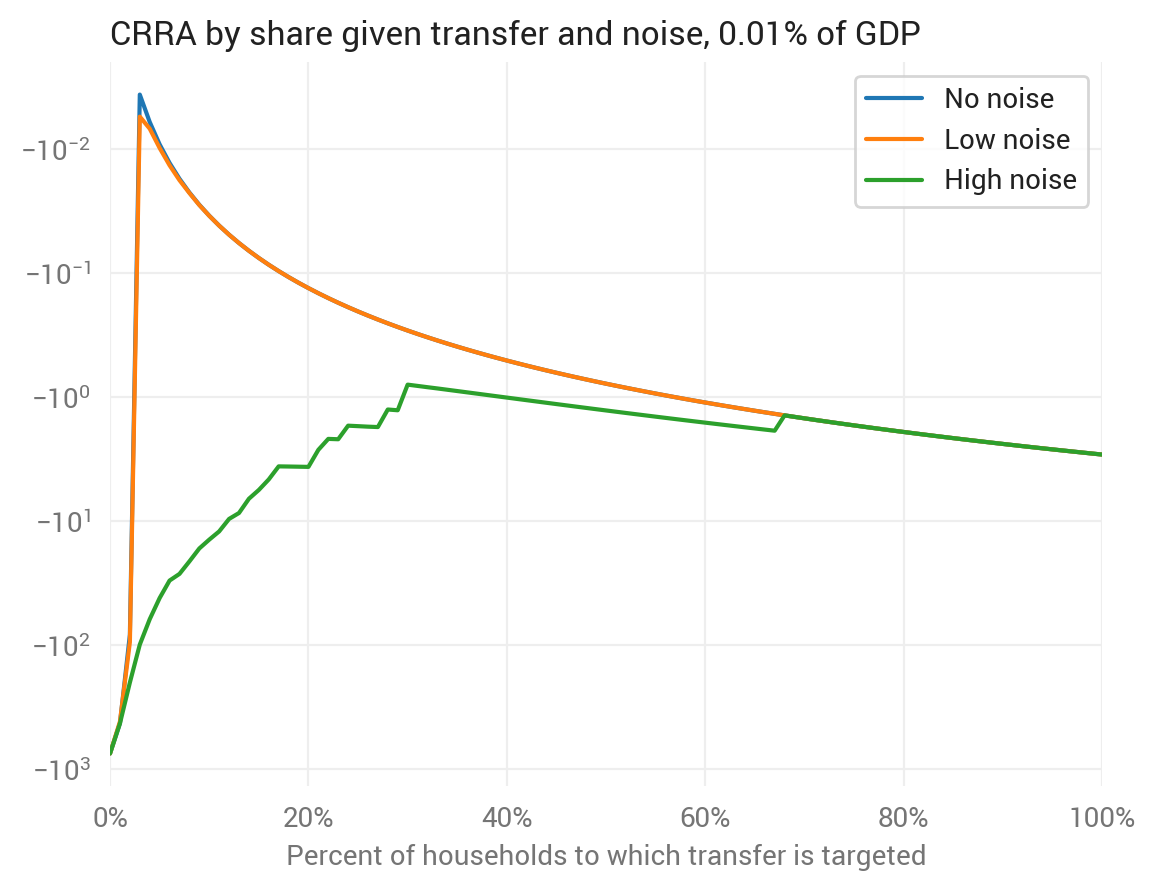

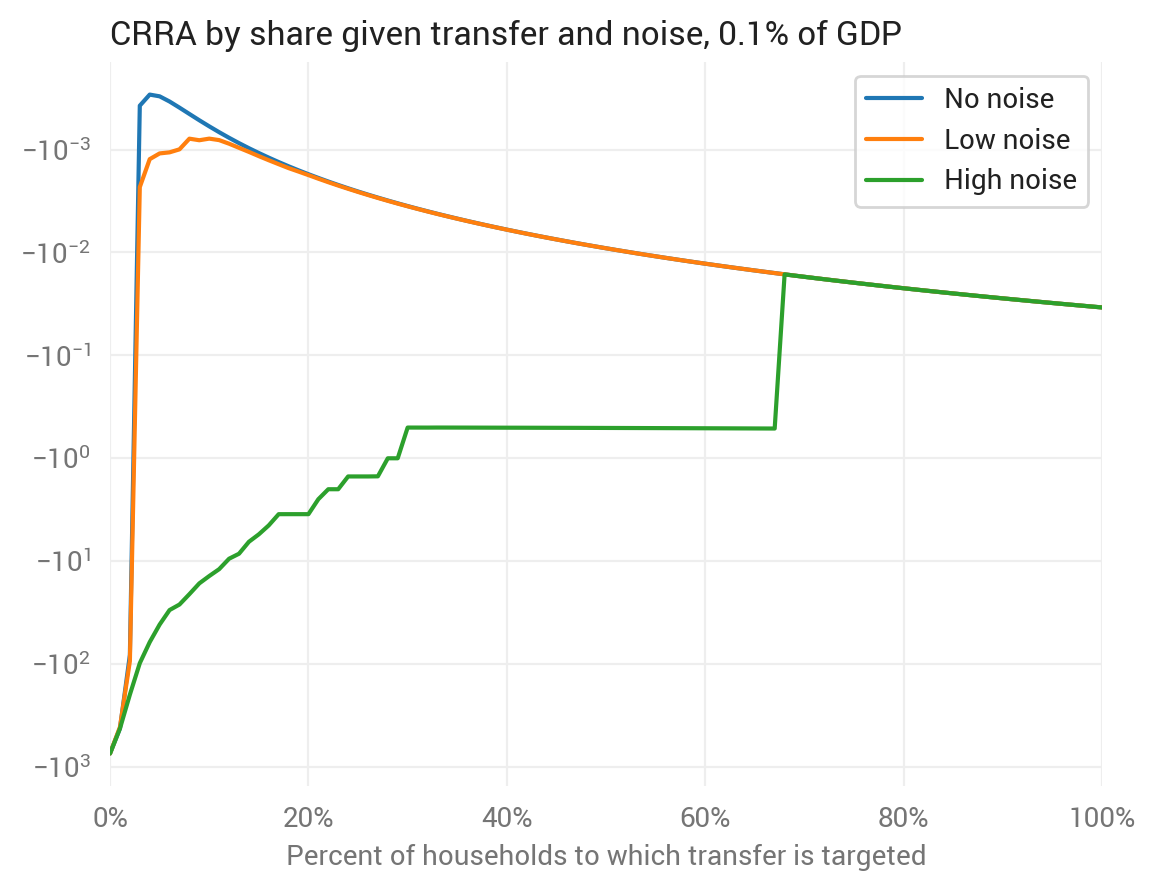

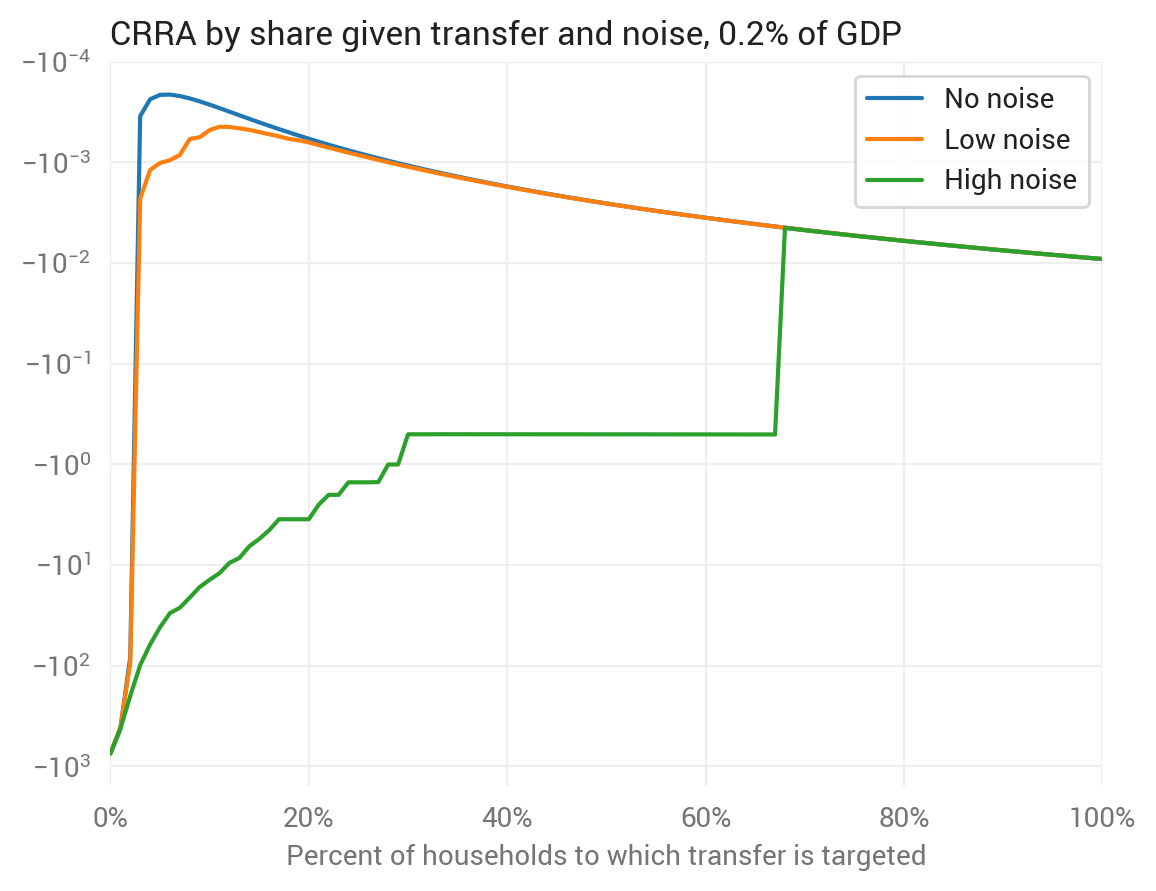

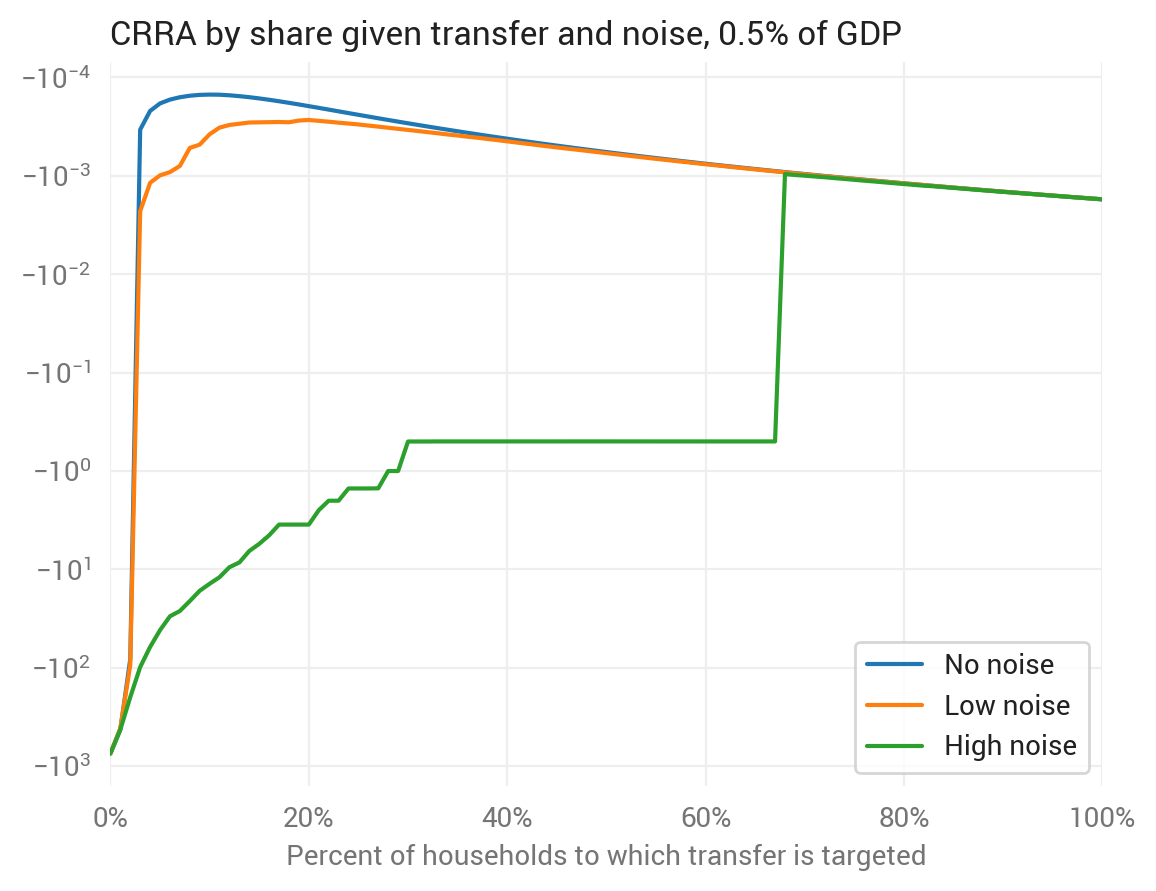

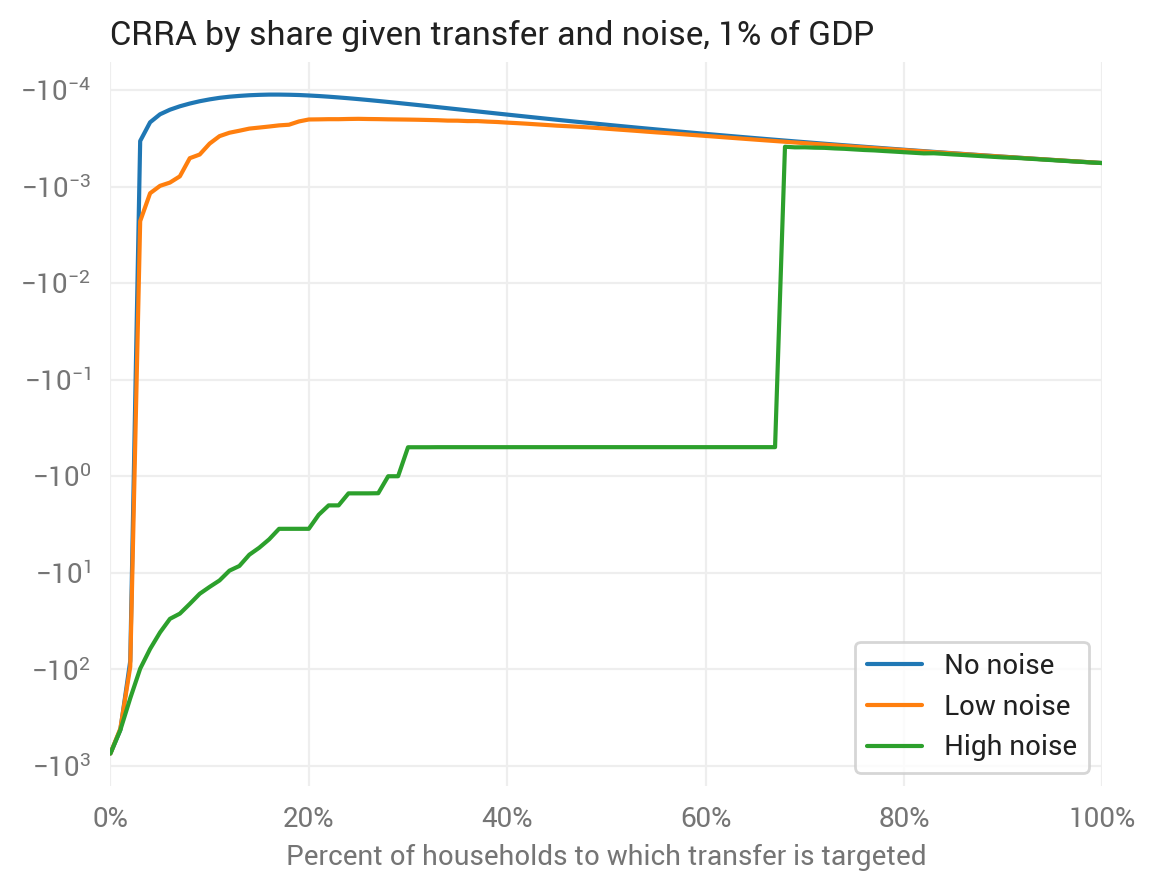

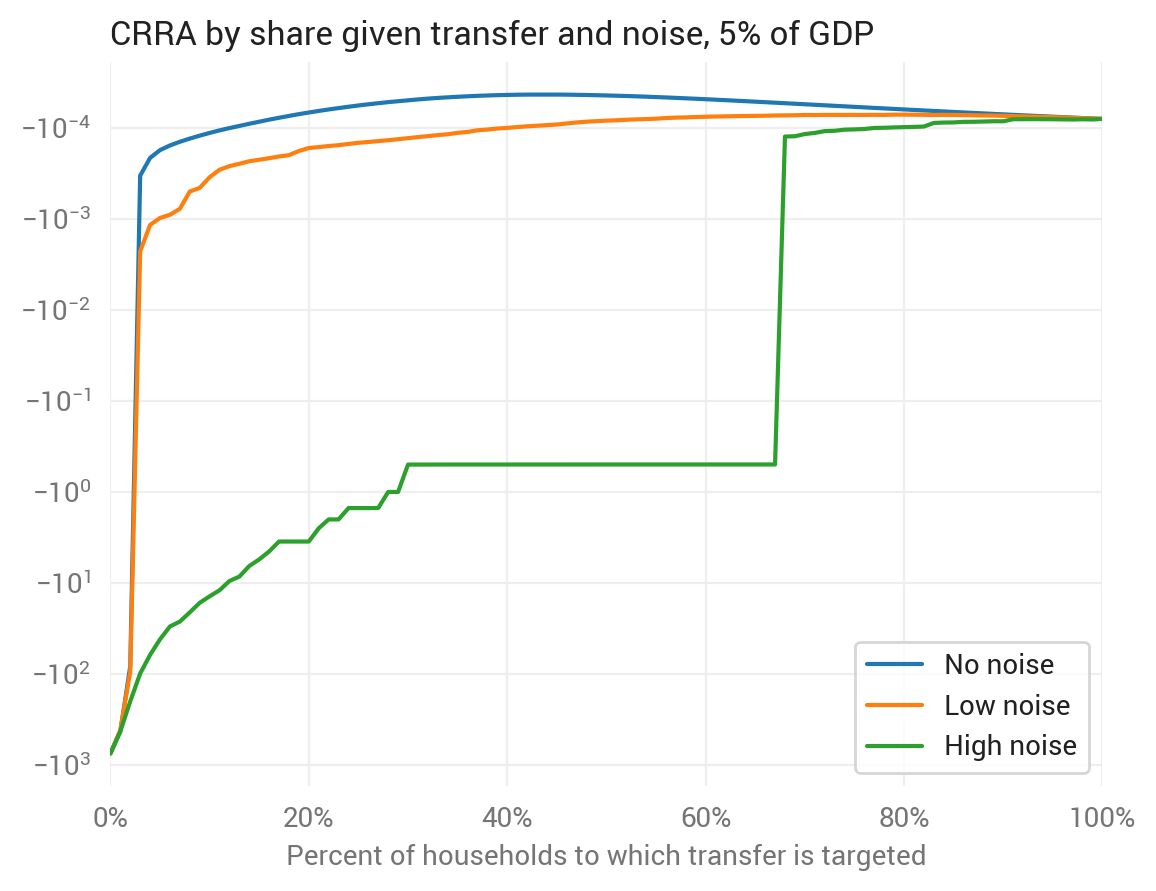

In [0]:
for budget in SIMX['budget_share_of_gdp']:
    plot_by_noise(budget, 0)

### Graphs with UBI

Improvement when allowing for a UBI share.

In [0]:
improvement_plot = optimal_targeting_joined.improvement.reset_index().pivot(
    'budget_share_of_gdp', 'noise', 'improvement'
)
improvement_plot *= 100  # For plotting.
improvement_plot

noise,No noise,Low noise,High noise
budget_share_of_gdp,,,
0.01,0.0,0.000000,64.734491
0.10,0.0,0.163088,73.706000
0.20,0.0,0.000000,66.724172
0.50,0.0,0.000000,47.952804
1.00,0.0,3.489644,30.861494
5.00,0.0,8.313828,11.465953


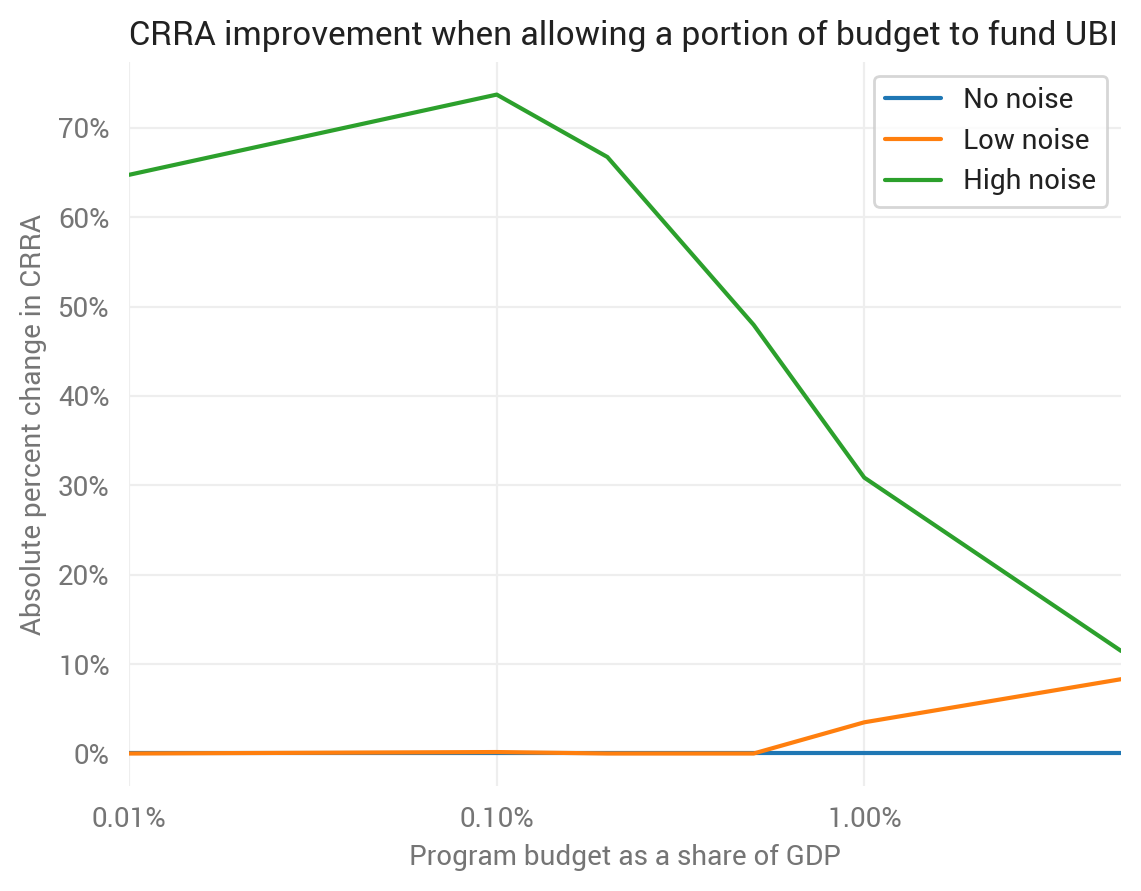

In [0]:
ax = improvement_plot.plot()
plt.title('CRRA improvement when allowing a portion of budget to fund UBI',
            loc='left')
plt.xlabel('Program budget as a share of GDP')
plt.ylabel('Absolute percent change in CRRA')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.PercentFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.PercentFormatter())
ax.legend(title='')
plt.show()